In [116]:
import pandas as pd
import numpy as np
from tabulate import tabulate

# import statmodels
import statsmodels.formula.api as smf
from statsmodels.graphics.factorplots import interaction_plot
import statsmodels.api as sm

#### Some utulity functions

In [359]:
def create_2cat_table(data, cat_var1, cat_var2, observation):
    '''
    cerate tables for anova observation
    input: 
        data: dataset type of panda dataframe
        cat_var1: label of first cat variable
        cat_var2: label of second cat variable
        observation: label of traget variable
        
    
    '''
    
    # list for storing tabulate data
    tabulate_list = []

    # iterate over first var
    for cat_1 in np.unique(data[cat_var1]):

        sub_group=''
        sub_len=''
        sub_mean=''
        sub_std=''

        # iterate over second var
        for cat_2 in np.unique(data[cat_var2]):

            # get value for given cat_1 and cat_2
            tmp_data = data[(data[cat_var1]==cat_1) & (data[cat_var2]==cat_2)][observation]

            # labels
            sub_group=sub_group+'\n'+cat_2
            
            # values
            sub_len=sub_len+'\n'+str(len(tmp_data))
            sub_mean=sub_mean+'\n'+ '%.2f' % np.mean(tmp_data)
            sub_std=sub_std+'\n'+ '%.2f' % np.std(tmp_data)

        # add to main tabulate list
        tabulate_list.append([cat_1, sub_group, sub_len, sub_mean, sub_std,
                             np.mean(data[data[cat_var1]==cat_1][observation]),
                             np.std(data[data[cat_var1]==cat_1][observation])])

    # print tabulate
    print(tabulate(tabulate_list, headers=[cat_var1, cat_var2, 'N', 
                                        observation+'\nmean', 
                                        observation+'\nstd',
                                        observation+'\nmean_all', 
                                        observation+'\nstd_all'], tablefmt='grid'))

In [360]:
def create_1cat_table(data, cat_var1, observation):
    '''
    cerate tables for anova observation
    input: 
        data: dataset type of panda dataframe
        cat_var1: label of first cat variabl
        observation: label of traget variable
    '''
    
    # list for storing tabulate data
    tabulate_list = []

    # iterate over first var
    for cat_1 in np.unique(data[cat_var1]):
     
        # get value for given cat_1 and cat_2
        tmp_data = data[data[cat_var1]==cat_1][observation]

        # add to main tabulate list
        tabulate_list.append([cat_1, len(tmp_data), 
                              '%.2f' % np.mean(tmp_data),
                              '%.2f' % np.std(tmp_data)])

    # print tabulate
    print(tabulate(tabulate_list, headers=[cat_var1, 'N', 
                                        observation+'\nmean', 
                                        observation+'\nstd'], tablefmt='grid'))

#### Load data

In [361]:
# load data
data = pd.read_csv ('Dataset_heart rate_retail stores.csv')

data.columns

Index(['Id', 'age', 'gender', 'BMI', 'sleeping_time',
       'sporting_activity_(h/week)', 'daytime', 'outdoor_temperature',
       'shopping_cart', 'attendants', 'shopping_frequency', 'cash_point',
       'shopping_amount', 'weekday', 'smoking', 'ex_max', 'ex_min', 'hr_max',
       'max_time', 'hr_min', 'min_time', 'shopping duration (in minutes)',
       'reaching HRmax'],
      dtype='object')

In [362]:
# raname shopping duration (in minutes) for easy handling
data=data.rename(columns = {'shopping duration (in minutes)':'shop_dur'})

### Create categorical vars

Create new categorical variables from exsisting ones  to use in the anova date

#### 1.  for age groups

In [363]:
# make new categorical data
intervals = [18, 31, 45, 60, 72]
levels =["18-31", "31-45", "45-60", "60+"]
data["age_groups"]=pd.cut(data["age"], intervals, labels=levels, include_lowest=True)

# factor data
data['age_groups'] = data['age_groups'].astype(str)

#### 2. for outdoor_temperature

In [364]:
intervals = [12, 18, 24, 28]
levels =["12-18", "18-24", "24+"]
data["out_t_groups"]=pd.cut(data["outdoor_temperature"], intervals, labels=levels, include_lowest=True)

# factorize data
data['out_t_groups'] = data['out_t_groups'].astype(str)

#### 3. for sporting_activity_(h/week)

In [365]:
intervals = [0, 2, 14]
levels =["0-2", "2+"]
data["sport_activity_groups"]=pd.cut(data["sporting_activity_(h/week)"], intervals, labels=levels, include_lowest=True)

# factorize data
data['sport_activity_groups'] = data['sport_activity_groups'].astype(str)

#### 4. for sleeping_time

In [366]:
intervals = [0, 6, 9, 12]
levels =["0-6", "6-9", "9+"]
data["sleeping_time_groups"]=pd.cut(data["sleeping_time"], intervals, labels=levels, include_lowest=True)

# factorize data
data['sleeping_time_groups'] = data['sleeping_time_groups'].astype(str)

#### 5. for ex_max

In [405]:
intervals = np.linspace(min(data['ex_max']), max(data['ex_max']), 7)
levels =["70-83", "93-96", "96-109", "109-122", "122-135", "135+"]
data['ex_max_groups']=pd.cut(data['ex_max'], intervals, labels=levels, include_lowest=True)

# factorize data
data['ex_max_groups'] = data['ex_max_groups'].astype(str)

#### 6. for ex_min

In [410]:
intervals = np.linspace(min(data['ex_min']), max(data['ex_min']), 7)
levels =["44-56", "56-69", "69-82", "82-94", "94-107", "107+"]
data['ex_min_groups']=pd.cut(data['ex_min'], intervals, labels=levels, include_lowest=True)

# factorize data
data['ex_min_groups'] = data['ex_min_groups'].astype(str)

In [411]:
data.head()

,Id,age,gender,BMI,sleeping_time,sporting_activity_(h/week),daytime,outdoor_temperature,shopping_cart,attendants,...,hr_min,min_time,shop_dur,reaching HRmax,age_groups,out_t_groups,sport_activity_groups,sleeping_time_groups,ex_max_groups,ex_min_groups
0,1,55,female,30.0,7.0,2.0,noon,23,no,no,...,72,4,12,0,45-60,18-24,0-2,6-9,109-122,69-82
1,2,25,female,18.4,9.0,1.0,noon,23,yes,no,...,70,18,26,0,18-31,18-24,0-2,6-9,109-122,69-82
2,3,38,male,25.1,5.0,3.0,noon,23,no,no,...,75,20,24,0,31-45,18-24,2+,0-6,109-122,69-82
3,4,21,female,22.6,8.0,0.0,evening,23,yes,family,...,62,41,46,0,18-31,18-24,0-2,6-9,135+,44-56
4,5,30,female,21.7,12.0,10.0,evening,23,yes,life partner,...,61,20,41,1,18-31,18-24,2+,9+,109-122,44-56


# ANOVA test

## 1. shop_dur ~ age_groups + gender + age_groups*gender 

In [368]:
create_2cat_table(data, 'age_groups', 'gender', 'shop_dur')

+--------------+----------+-----+------------+------------+------------+------------+
| age_groups   | gender   | N   | shop_dur   | shop_dur   |   shop_dur |   shop_dur |
|              |          |     | mean       | std        |   mean_all |    std_all |
+==============+==========+=====+============+============+============+============+
| 18-31        | female   | 35  | 38.57      | 22.76      |    37.661  |    20.7386 |
|              | male     | 24  | 36.33      | 17.29      |            |            |
+--------------+----------+-----+------------+------------+------------+------------+
| 31-45        | female   | 22  | 34.32      | 17.61      |    33.9375 |    20.068  |
|              | male     | 26  | 33.62      | 21.93      |            |            |
+--------------+----------+-----+------------+------------+------------+------------+
| 45-60        | female   | 24  | 35.12      | 14.12      |    33.814  |    14.995  |
|              | male     | 19  | 32.16      | 15.88  

#### Calculate anova

In [369]:
data['age_groups'] = data['age_groups'].astype(str)

lm = smf.ols('shop_dur ~ age_groups + gender + age_groups*gender ', data=data).fit()
sm.stats.anova_lm(lm, type=1)

,df,sum_sq,mean_sq,F,PR(>F)
age_groups,3.0,520.304018,173.434673,0.453993,0.714841
gender,1.0,217.155221,217.155221,0.568438,0.452010
age_groups:gender,3.0,83.836357,27.945452,0.073152,0.974298
Residual,157.0,59977.286223,382.020931,NaN,NaN


As we can see from the PR(>F) values, n-Anova test doesn't suggest a significant difference between the effects of age_groups and gender on shopping duration. Also, we can see from the interaction term that the interaction of given factors don't have a significant effect on the response var. 

#### Interaction plot

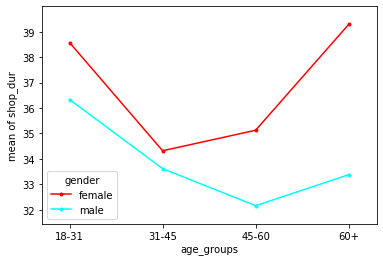

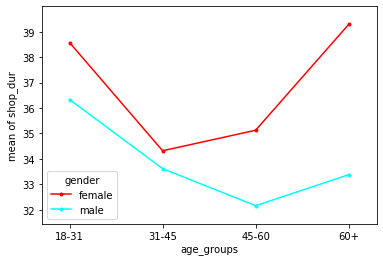

In [370]:
interaction_plot(data['age_groups'], data['gender'], data['shop_dur'])

Although general interaction is not significant, we can still see the relatively considerable difference between genders on 60+ age groups.

## 2. shop_dur ~ age_groups

In [371]:
create_1cat_table(data, 'age_groups', 'shop_dur')

+--------------+-----+------------+------------+
| age_groups   |   N |   shop_dur |   shop_dur |
|              |     |       mean |        std |
+==============+=====+============+============+
| 18-31        |  59 |      37.66 |      20.74 |
+--------------+-----+------------+------------+
| 31-45        |  48 |      33.94 |      20.07 |
+--------------+-----+------------+------------+
| 45-60        |  43 |      33.81 |      14.99 |
+--------------+-----+------------+------------+
| 60+          |  15 |      36.13 |      19.84 |
+--------------+-----+------------+------------+


#### Calculate annova

In [372]:
lm = smf.ols('shop_dur ~ age_groups', data=data).fit()
sm.stats.anova_lm(lm, type=1)

,df,sum_sq,mean_sq,F,PR(>F)
age_groups,3.0,520.304018,173.434673,0.463235,0.708344
Residual,161.0,60278.277800,374.399241,NaN,NaN


We don't find a significant main effect of age groups (F = 0.46, p > .70) on shopping durations.

## 3. shop_dur ~ out_t_groups

In [373]:
create_1cat_table(data, 'out_t_groups', 'shop_dur')

+----------------+-----+------------+------------+
| out_t_groups   |   N |   shop_dur |   shop_dur |
|                |     |       mean |        std |
+================+=====+============+============+
| 12-18          |  50 |      42    |      19.37 |
+----------------+-----+------------+------------+
| 18-24          |  89 |      32.19 |      19.23 |
+----------------+-----+------------+------------+
| 24+            |  26 |      33.92 |      15.15 |
+----------------+-----+------------+------------+


#### Calculate anova

In [374]:
lm = smf.ols('shop_dur ~ out_t_groups', data=data).fit()
sm.stats.anova_lm(lm, type=1)

,df,sum_sq,mean_sq,F,PR(>F)
out_t_groups,2.0,3150.982855,1575.491428,4.427411,0.013425
Residual,162.0,57647.598963,355.849376,NaN,NaN


As it's also clear from the table, the ANOVA test suggests us that response of temperature groups on shopping duration is important where  (F = 4.42, p < 0.013). Especially we can come to the conculusion that people ofen go shippoing during the cool days.

## 4. shop_dur ~  out_t_groups + gender + out_t_groups*gender

In [375]:
create_2cat_table(data, 'out_t_groups', 'age_groups', 'shop_dur')

+----------------+--------------+-----+------------+------------+------------+------------+
| out_t_groups   | age_groups   | N   | shop_dur   | shop_dur   |   shop_dur |   shop_dur |
|                |              |     | mean       | std        |   mean_all |    std_all |
+================+==============+=====+============+============+============+============+
| 12-18          | 18-31        | 20  | 36.55      | 21.20      |    42      |    19.368  |
|                | 31-45        | 13  | 47.00      | 22.26      |            |            |
|                | 45-60        | 14  | 45.29      | 12.33      |            |            |
|                | 60+          | 3   | 41.33      | 6.55       |            |            |
+----------------+--------------+-----+------------+------------+------------+------------+
| 18-24          | 18-31        | 26  | 40.65      | 22.84      |    32.191  |    19.233  |
|                | 31-45        | 33  | 28.15      | 16.80      |            |  

#### Calculate anova

In [376]:
lm = smf.ols('shop_dur ~ out_t_groups + age_groups + out_t_groups*age_groups ', data=data).fit()
sm.stats.anova_lm(lm, type=1)

,df,sum_sq,mean_sq,F,PR(>F)
out_t_groups,2.0,3150.982855,1575.491428,4.545497,0.012088
age_groups,3.0,439.144034,146.381345,0.422329,0.737251
out_t_groups:age_groups,6.0,4177.904935,696.317489,2.008966,0.067721
Residual,153.0,53030.549994,346.604902,NaN,NaN


#### Interaction plot

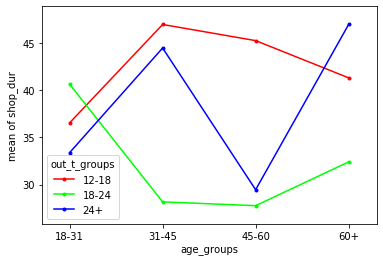

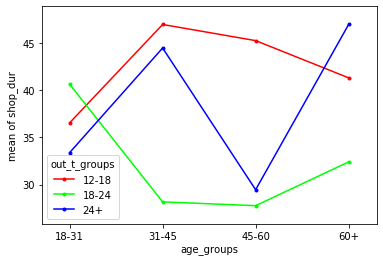

In [377]:
interaction_plot(data['age_groups'], data['out_t_groups'], data['shop_dur'])

Interaction between outdoor temperature groups and age groups is not significant, but close to rejection interval (F > 0.06). As it's clear from the above plot, it's that still can be important for capturing some pattern on customer behaviour. From the interaction plot, we can see temperature has a relatively important effect on customer's behaviours from 31-45, 45-60, 60+ age groups. Where it's very close among 18-31.  

## 5. shop_dur ~ attendants

In [378]:
create_1cat_table(data, 'attendants', 'shop_dur')

+---------------+-----+------------+------------+
| attendants    |   N |   shop_dur |   shop_dur |
|               |     |       mean |        std |
+===============+=====+============+============+
| family        |  13 |      47.08 |      24.37 |
+---------------+-----+------------+------------+
| family member |  15 |      40.07 |      23    |
+---------------+-----+------------+------------+
| life partner  |  53 |      43.43 |      16.62 |
+---------------+-----+------------+------------+
| little child  |   6 |      38.83 |      12.88 |
+---------------+-----+------------+------------+
| no            |  78 |      26.91 |      15.32 |
+---------------+-----+------------+------------+


In [379]:
lm = smf.ols('shop_dur ~ attendants', data=data).fit()
sm.stats.anova_lm(lm, type=1)

,df,sum_sq,mean_sq,F,PR(>F)
attendants,4.0,11212.501412,2803.125353,9.044878,0.000001
Residual,160.0,49586.080406,309.913003,NaN,NaN


Having F < 0.000001, ANOVA test shows us that shopping duration upon attendants varies significantly from each other. We can also see from the table that, people spend more time on shopping when they're with family or life partner than they're alone. 

## 6. shop_dur ~ shopping_cart

In [380]:
create_1cat_table(data, 'shopping_cart', 'shop_dur')

+-----------------+-----+------------+------------+
| shopping_cart   |   N |   shop_dur |   shop_dur |
|                 |     |       mean |        std |
+=================+=====+============+============+
| no              |  66 |      25.41 |      15.29 |
+-----------------+-----+------------+------------+
| yes             |  99 |      42.12 |      18.62 |
+-----------------+-----+------------+------------+


#### Calculate anova

In [381]:
lm = smf.ols('shop_dur ~ shopping_cart', data=data).fit()
sm.stats.anova_lm(lm, type=1)

,df,sum_sq,mean_sq,F,PR(>F)
shopping_cart,1.0,11060.081818,11060.081818,36.24543,1.114950e-08
Residual,163.0,49738.500000,305.144172,NaN,NaN


Here we can see that the null hypothesis is externally week. This suggests that taking a shopping cart on shopping definitely increase the duration of time a customer spends on shopping. This can be an important insight for markets on finding ways to increase the time customer spend on shopping, thus spend more money. 

## 7. shop_dur ~ smoking

In [382]:
create_1cat_table(data, 'smoking', 'shop_dur')

+-----------+-----+------------+------------+
|   smoking |   N |   shop_dur |   shop_dur |
|           |     |       mean |        std |
+===========+=====+============+============+
|         0 | 104 |      37.84 |      20.64 |
+-----------+-----+------------+------------+
|         1 |  61 |      31.34 |      15.61 |
+-----------+-----+------------+------------+


#### Calculate anova

In [383]:
lm = smf.ols('shop_dur ~ smoking', data=data).fit()
sm.stats.anova_lm(lm, type=1)

,df,sum_sq,mean_sq,F,PR(>F)
smoking,1.0,1620.590173,1620.590173,4.463757,0.036145
Residual,163.0,59177.991646,363.055163,NaN,NaN


We can also see that customer who's smoker are intend to spend less time inside shopping. Using this insight, companies can look for ways to attract smokers customer intention, so they'll spend more time on shopping.

## 8.  
#### shop_dur ~ daytime + sleeping_time_groups + sport_activity_groups + daytime*sleeping_time_groups + daytime*sport_activity_groups +sleeping_time_groups*sport_activity_groups

In [384]:
create_1cat_table(data, 'sleeping_time_groups', 'shop_dur')

+------------------------+-----+------------+------------+
| sleeping_time_groups   |   N |   shop_dur |   shop_dur |
|                        |     |       mean |        std |
+========================+=====+============+============+
| 0-6                    |  42 |      31    |      16.33 |
+------------------------+-----+------------+------------+
| 6-9                    | 114 |      36.28 |      19.47 |
+------------------------+-----+------------+------------+
| 9+                     |   9 |      45.44 |      22.5  |
+------------------------+-----+------------+------------+


#### Calcualate anova

In [385]:
lm = smf.ols('shop_dur ~ daytime + sleeping_time_groups + sport_activity_groups\
            + daytime*sleeping_time_groups + daytime*sport_activity_groups\
            + sleeping_time_groups*sport_activity_groups', data=data).fit()
sm.stats.anova_lm(lm, type=1)

,df,sum_sq,mean_sq,F,PR(>F)
daytime,2.0,406.019115,203.009558,0.573359,0.564851
sleeping_time_groups,2.0,1854.332747,927.166374,2.618591,0.076214
sport_activity_groups,1.0,562.616572,562.616572,1.588995,0.209414
daytime:sleeping_time_groups,4.0,1580.586276,395.146569,1.116010,0.351135
daytime:sport_activity_groups,2.0,964.537245,482.268622,1.362069,0.259259
sleeping_time_groups:sport_activity_groups,2.0,1965.813795,982.906898,2.776019,0.065468
Residual,151.0,53464.676068,354.070702,NaN,NaN


Here we have calculated ANOVA response of daytime, sleeping time, sports activities number and their interaction on shopping duration. We only observed relatively significant (but not close enough to reject H0) on sleeping time group and interaction of sleeping time groups with activity groups, F value of being >0.076 and >0.654 respectively. It's aslo clear in the table above.

#### Interaction plot

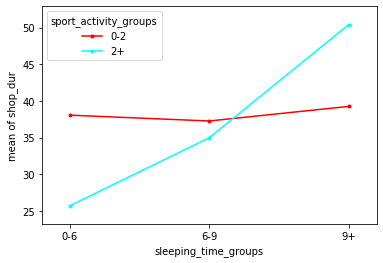

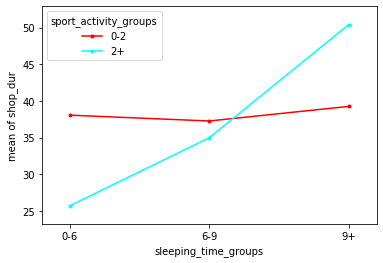

In [386]:
interaction_plot(data['sleeping_time_groups'], data['sport_activity_groups'], data['shop_dur'])

Interaction plot suggests that people who sleep more than 9 hours and actively participate in sports activities tended to spend more time in shopping.

### 9. shop_dur ~ ex_max_groups (ex_min_groups)

#### Calculate annova

In [430]:
lm = smf.ols('shop_dur ~ ex_max_groups', data=data).fit()
sm.stats.anova_lm(lm, type=1)

,df,sum_sq,mean_sq,F,PR(>F)
ex_max_groups,5.0,831.254884,166.250977,0.440805,0.819471
Residual,159.0,59967.326934,377.153000,NaN,NaN


In [431]:
lm = smf.ols('shop_dur ~ ex_min_groups', data=data).fit()
sm.stats.anova_lm(lm, type=1)

,df,sum_sq,mean_sq,F,PR(>F)
ex_min_groups,5.0,1228.543383,245.708677,0.655828,0.657481
Residual,159.0,59570.038436,374.654330,NaN,NaN


Annova test alone suggests that given ex_mag_groups and ex_min_groups don't show any different distribution on the response variable, thus not important for capturing necessary information.